In [1]:
import numpy as np
from numpy import random as rnd
from matplotlib import pyplot as plt
import os,warnings,datetime,time,sys,itertools

import torch
from torch import functional as F

import pandas as pd

In [2]:
# Root path
basepath = '../../../../../../../../TF_data/ADMIN/v3/'

# Single Transactions directory
single_transactions_path = basepath + '01_SingleTransactions/'

# Account Totals Tracker
totals_path = basepath + '02_AccountTotal/'

In [3]:
# Select latest file in Single Transactions directory

target_by_date = dict()
for filename in os.listdir(single_transactions_path):
    if filename.startswith('.'): continue
    try:
        datestr = filename.split('-')[0]
        date = datetime.datetime.strptime(datestr,'%Y%m%d')
        target_by_date[date] = filename 
    except:
        continue

# Sort dictionary by keys and select latest
latest_filename = sorted(target_by_date.items())[0][1]

In [9]:
# Read file

df0 = pd.read_csv(single_transactions_path+latest_filename,sep=';',encoding='latin-1')
df0['Origin'] = latest_filename
df0['Betrag'] = df0['Betrag'].apply(lambda x: str(x)[:-2]+'.'+str(x)[-2:] if ',' not in str(x) and '.' not in str(x) else str(x).replace(',','.'))

In [10]:
# Convert amt column to float
df0['Betrag'] = df0['Betrag'].astype(np.float)

In [11]:
# Remove duplicate entries
df0 = df0.reset_index(drop=True)
df0 = df0.loc[df0.drop(columns=['Origin']).drop_duplicates().index.tolist()]

In [12]:
# Double fields

cols = [
    'Betrag'
]

for col in cols:
    df0[col] = df0[col].astype(np.double)

In [13]:
# Date fields

cols = [
    'Buchungstag',
    'Valutadatum'
]

for col in cols:
    df0[col] = pd.to_datetime(df0[col],format='%d.%m.%y')

In [14]:
# Load ground truth

df1 = pd.read_excel(totals_path+'AccountTracker.xlsx')

In [15]:
datecol = 'Valutadatum'

t0 = df0.copy()[[datecol,'Betrag']]
t0['Booked Month'] = t0.apply(lambda x: x[datecol].strftime('%Y-%m'),axis=1)
t0 = t0.drop(columns=[datecol])

t0 = t0.groupby('Booked Month').sum().rename(columns={'Betrag':'Spending'})

In [16]:
t1 = df1.copy()[['Date','Account Total']]
t1['Month'] = t1.apply(lambda x: x['Date'].strftime('%Y-%m'),axis=1)
t1 = t1.drop(columns=['Date']).set_index('Month')

<AxesSubplot:>

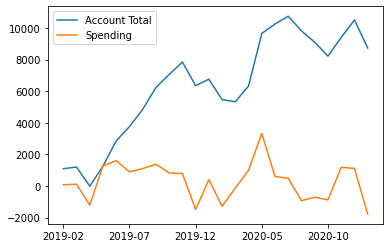

In [17]:
ff = t1.merge(t0,how='inner',left_index=True,right_index=True)
ff.plot()

In [18]:
ff['Prev Month Totals'] = ff['Account Total'].shift(1)
ff['Predicted Total'] = ff.apply(lambda x: x['Spending']+x['Prev Month Totals'],axis=1)
ff['Forecast Error'] = ff.apply(lambda x: x['Account Total']-x['Predicted Total'],axis=1)

<AxesSubplot:>

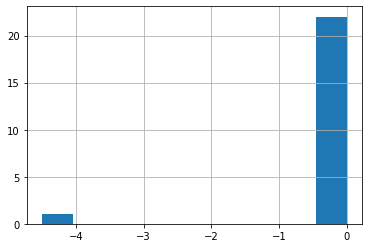

In [19]:
ff['Forecast Error'].hist()

In [20]:
def encode_categories(df_in,overwrite_existing=False):
    df = df_in.copy()
    # If category column not in dataframe, create it
    if 'Category' not in df.columns:
        df['Category'] = np.nan
    # If category column partially filled, store where filled
    remerge = False
    if overwrite_existing:
        df['Category'] = np.nan
    else:
        df_filled = df[~df['Category'].isna()]
        df = df[df['Category'].isna()]
        remerge = True
    #
    # All mappings go here
    #
    # Mapping: Salary
    try:
        df.at[df[df.apply(lambda x: 
            (str(x['Buchungstext'])=='LOHN  GEHALT') and
            (str(x['Kontonummer/IBAN'])=='DE90700500000002055382')
        ,axis=1)].index,'Category'] = 'SALARY'
    except:
        print('Category <SALARY> could not be determined, lacking data columns')
    # Mapping: Lunch money
    try:
        df.at[df[df.apply(lambda x: 
            (str(x['Buchungstext'])=='FOLGELASTSCHRIFT') and
            (str(x['Beguenstigter/Zahlungspflichtiger'])=='Siemens Aktiengesellschaft') and
            (str(x['Kontonummer/IBAN'])=='DE53700700100203008800')
        ,axis=1)].index,'Category'] = 'FOOD'
    except:
        print('Category <FOOD> could not be determined, lacking data columns')
    # Mapping: RENT
    try:
        df.at[df[df.apply(lambda x: 
            ('miete' in str(x['Verwendungszweck']).lower()) and 
            (str(x['Kontonummer/IBAN']) in ['DE06120300001056103045','DE46763500000044116613'])
        ,axis=1)].index,'Category'] = 'RENT'
    except:
        print('Category <RENT> could not be determined, lacking data columns')
    # Mapping: INTERNETCOST
    try:
        df.at[df[df.apply(lambda x: 
            ('m-net telekommunikations gmbh' in str(x['Beguenstigter/Zahlungspflichtiger']).lower()) and 
            (str(x['Kontonummer/IBAN']) in ['DE74700500000000028273'])
        ,axis=1)].index,'Category'] = 'INTERNETCOST'
    except:
        print('Category <INTERNETCOST> could not be determined, lacking data columns')
    # Mapping: STOCKSPURCHASE
    try:
        df.at[df[df.apply(lambda x: 
          ( ('dekabank' in str(x['Beguenstigter/Zahlungspflichtiger']).lower()) and 
            (str(x['Kontonummer/IBAN']) in ['DE02500509990000022889']) and 
            ('wertpapiere' in str(x['Buchungstext']).lower())
          ) or (
              (str(x['Kontonummer/IBAN']) in ['DE55300308803960761048']) and
              (str(x['Buchungstext'])=='GUTSCHR. UEBERWEISUNG')
          )
        ,axis=1)].index,'Category'] = 'STOCKSPURCHASE'
    except:
        print('Category <STOCKSPURCHASE> could not be determined, lacking data columns')
    # Mapping: INSURANCE
    try:
        df.at[df[df.apply(lambda x: 
            (str(x['Buchungstext']).lower()=='folgelastschrift') and 
            (str(x['Kontonummer/IBAN']) in ['DE44700800000564460402','DE04300500000000444166'])
        ,axis=1)].index,'Category'] = 'INSURANCE'
    except:
        print('Category <INSURANCE> could not be determined, lacking data columns')
    # Mapping: PHONECONTRACT
    try:
        df.at[df[df.apply(lambda x: 
            (str(x['Buchungstext']).lower()=='folgelastschrift') and 
            (str(x['Kontonummer/IBAN']) in ['DE68700202700667302269'])
        ,axis=1)].index,'Category'] = 'PHONECONTRACT'
    except:
        print('Category <PHONECONTRACT> could not be determined, lacking data columns')
    # Mapping: UTILITIES
    try:
        df.at[df[df.apply(lambda x: 
            ('estw' in str(x['Beguenstigter/Zahlungspflichtiger']).lower()) and 
            (str(x['Kontonummer/IBAN']) in ['DE06763200720004536703'])
        ,axis=1)].index,'Category'] = 'UTILITIES'
    except:
        print('Category <UTILITIES> could not be determined, lacking data columns')
    # Mapping: GYMCOST
    try:
        df.at[df[df.apply(lambda x: 
            (str(x['Kontonummer/IBAN']) in ['DE88763500000000062725','DE85763500000000001669'])
        ,axis=1)].index,'Category'] = 'GYMCOST'
    except:
        print('Category <GYMCOST> could not be determined, lacking data columns')
    # Mapping: IGMETALL
    try:
        df.at[df[df.apply(lambda x: 
            (str(x['Kontonummer/IBAN']) in ['DE28500500000083044008'])
        ,axis=1)].index,'Category'] = 'IGMETALL'
    except:
        print('Category <IGMETALL> could not be determined, lacking data columns')
    #
    # Mapping section ends here
    #
    # Append partially filled column if it was there
    if remerge:
        df = pd.concat([df,df_filled])
    return df

In [53]:
datecol = 'Valutadatum'

df = encode_categories(df0)[[datecol,'Betrag','Category']]
df = df[df['Category'].isna()]

df['Booked Month'] = df.apply(lambda x: x[datecol].strftime('%Y-%m'),axis=1)
df = df.drop(columns=[datecol,'Category'])

In [64]:
df = df.groupby(['Booked Month']).sum()

In [85]:
def explode_frame(df,datecol='Valutadatum'):
    # Restrict to required columns
    df = df[[datecol,'Betrag','Category']]
    # Fill remaning empty categories
    df['Category'] = df['Category'].fillna('UNCATEGORIZED')
    # Convert booked month
    df['Booked Month'] = df.apply(lambda x: x[datecol].strftime('%Y-%m'),axis=1)
    # Aggregate per month
    df = df[['Booked Month','Category','Betrag']].groupby(['Booked Month','Category']).sum().rename(columns={'Betrag':'Spending'})
    # Pivot table
    df = df.reset_index(drop=False).pivot(index='Booked Month',columns='Category',values='Spending').fillna(0)
    # Sum uncategorized
    df['00_CATEGORIZED'] = df[['FOOD','GYMCOST','IGMETALL','INSURANCE','INTERNETCOST','UNCATEGORIZED','UTILITIES']].sum(axis=1)
    # Explained share each month
    df['Explained Share'] = df.apply(lambda x: x['00_CATEGORIZED']/(x['00_CATEGORIZED']+x['UNCATEGORIZED']),axis=1)
    # Return dataframe
    return df

In [91]:
df = encode_categories(df0.copy())
tt = explode_frame(df)[['00_CATEGORIZED','UNCATEGORIZED','Explained Share']]

<ipython-input-85-6d7130ea8464>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Category'] = df['Category'].fillna('UNCATEGORIZED')
<ipython-input-85-6d7130ea8464>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Booked Month'] = df.apply(lambda x: x[datecol].strftime('%Y-%m'),axis=1)


In [92]:
tt

Category,00_CATEGORIZED,UNCATEGORIZED,Explained Share
Booked Month,,,
2019-02,-368.55,-185.52,0.665169
2019-03,-335.38,-211.53,0.613227
2019-04,-949.52,-731.49,0.564851
2019-05,866.22,990.07,0.466640
2019-06,-829.07,-636.22,0.565806
2019-07,-1055.13,-818.02,0.563292
2019-08,-1140.67,-907.15,0.557017
2019-09,-862.07,-607.33,0.586682
2019-10,-1413.79,-1122.46,0.557433
